In [1]:
import os
import json
from collections import defaultdict
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [2]:
poland_files = sorted(
    [
        file
        for file in os.listdir("../data/videos/last/poland")
        if file.endswith(".json") and "progress" not in file
    ]
)
us_files = sorted(
    [
        file
        for file in os.listdir("../data/videos/last/united-states")
        if file.endswith(".json") and "progress" not in file
    ]
)

files_df = pd.DataFrame(
    columns=["File name", "Objects number", "Country"],
    index=range(len(poland_files) + len(us_files)),
)
pl_data = []
us_data = []
for i, file in enumerate(poland_files):
    with open(f"../data/videos/last/poland/{file}", "r", encoding="utf-8") as f:
        data = json.load(f)
        pl_data.extend(data)
    files_df.loc[i] = [file, len(data), "Poland"]
for i, file in enumerate(us_files):
    with open(f"../data/videos/last/united-states/{file}", "r") as f:
        data = json.load(f)
        us_data.extend(data)
    files_df.loc[i + len(poland_files)] = [file, len(data), "United States"]

files_df

,File name,Objects number,Country
0,1 - 50.json,50,Poland
1,101 - 150.json,50,Poland
2,151 - 200.json,50,Poland
3,201 - 250.json,50,Poland
4,251 - 300.json,50,Poland
5,301 - 350.json,50,Poland
6,351 - 400.json,47,Poland
7,51 - 100.json,50,Poland


In [3]:
yt_categories = {
    "1": "Film & Animation",
    "2": "Autos & Vehicles",
    "10": "Music",
    "15": "Pets & Animals",
    "17": "Sports",
    "18": "Short Movies",
    "19": "Travel & Events",
    "20": "Gaming",
    "21": "Videoblogging",
    "22": "People & Blogs",
    "23": "Comedy",
    "24": "Entertainment",
    "25": "News & Politics",
    "26": "Howto & Style",
    "27": "Education",
    "28": "Science & Technology",
    "29": "Nonprofits & Activism",
    "30": "Movies",
    "31": "Anime/Animation",
    "32": "Action/Adventure",
    "33": "Classics",
    "34": "Comedy",
    "35": "Documentary",
    "36": "Drama",
    "37": "Family",
    "38": "Foreign",
    "39": "Horror",
    "40": "Sci-Fi/Fantasy",
    "41": "Thriller",
    "42": "Shorts",
    "43": "Shows",
    "44": "Trailers",
}

In [4]:
for channel_idx in range(len(pl_data)):
    try:
        video_categories_count = defaultdict(int)
        for video in pl_data[channel_idx]["videos"]:
            video_categories_count[yt_categories[video["category"]]] += 1
        pl_data[channel_idx]["channel"]["category"] = max(
            video_categories_count, key=video_categories_count.get
        )
    except ValueError:
        print(
            f"Channel {pl_data[channel_idx]['channel']['name']} has no videos - setting category to Unknown"
        )
        pl_data[channel_idx]["channel"]["category"] = "Unknown"

Channel TheNitroZyniak has no videos - setting category to Unknown
Channel MagdalenaMariaMonika has no videos - setting category to Unknown
Channel ZDROWE i SMACZNE przepisy. has no videos - setting category to Unknown
Channel skkf has no videos - setting category to Unknown


In [5]:
for channel_idx in range(len(us_data)):
    try:
        video_categories_count = defaultdict(int)
        for video in us_data[channel_idx]["videos"]:
            video_categories_count[yt_categories[video["category"]]] += 1
        us_data[channel_idx]["channel"]["category"] = max(
            video_categories_count, key=video_categories_count.get
        )
    except ValueError:
        print(
            f"Channel {us_data[channel_idx]['channel']['name']} has no videos - setting category to Unknown"
        )
        us_data[channel_idx]["channel"]["category"] = "Unknown"

In [6]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import emoji
import nltk
from num2words import num2words
from langdetect import detect, lang_detect_exception
from tqdm.notebook import tqdm
from transformers import pipeline

nltk.download("stopwords", quiet=True, raise_on_error=True, download_dir="../models/nltk_data")
nltk.download('punkt_tab', quiet=True, raise_on_error=True, download_dir="../models/nltk_data")
nltk.data.path.append("../models/nltk_data")

In [7]:
def get_translation_model(from_lang, to_lang):
    models_dir = "../models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    if not os.path.exists(f"{models_dir}/translation"):
        os.makedirs(f"{models_dir}/translation")
    if f"Helsinki-NLP/opus-mt-{from_lang}-{to_lang}" not in os.listdir(f"{models_dir}/translation"):
        return pipeline("translation", model=f"Helsinki-NLP/opus-mt-{from_lang}-{to_lang}")
    else:
        return pipeline(
            "translation",
            model=f"{models_dir}/translation/Helsinki-NLP/opus-mt-{from_lang}-{to_lang}",
        )


def save_translation_model(model, from_lang, to_lang):
    models_dir = "../models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    if not os.path.exists(f"{models_dir}/translation"):
        os.makedirs(f"{models_dir}/translation")
    model.save_pretrained(f"{models_dir}/translation/Helsinki-NLP/opus-mt-{from_lang}-{to_lang}")

In [8]:
def clean_text(text):
    pattern = r"""
        <.*?> |                               # HTML tags
        \b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b |  # Emails
        (https?:\/\/|www\.)\S+ |              # URLs starting with http, https, or www
        \b\S+\.(com|org|net|ly|co|ly|pl|uk)\b    # Specific domains
    """
    text = re.sub(pattern, "", text, flags=re.VERBOSE)
    return text


def text_lowercase(text: str):
    return text.lower()


def demojize(text: str) -> str:
    return emoji.replace_emoji(text, "")


def convert_number(text: str) -> str:
    words = text.split()
    for word in words:
        if word.isdigit():
            try:
                words[words.index(word)] = num2words(word)
            except ValueError:
                continue
    return text


def remove_punctuation(text: str) -> str:
    return text.translate(str.maketrans("", "", string.punctuation))


def remove_whitespace(text: str) -> str:
    return " ".join(text.split())


def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    return " ".join(word for word in words if word not in stop_words)


def translate_text(text: str, from_lang, to_lang) -> str:
    if from_lang == to_lang:
        return text
    try:
        model = get_translation_model(from_lang, to_lang)
        translation = model(text)
        save_translation_model(model, from_lang, to_lang)
        return translation[0]["translation_text"]
    except Exception as e:
        print(f"Translation failed: {e}")
        return ""

In [9]:
def preprocess_text(text: str, lang: str = None) -> str:

    text = clean_text(text)

    text = text_lowercase(text)

    text = remove_punctuation(text)

    text = remove_whitespace(text)
    
    text = demojize(text)
    
    if lang:
        text = convert_number(text)
        
        text = translate_text(text, lang, "en")

        text = remove_stopwords(text)

    return text

In [10]:
def get_category_distribution(channels):
    category_distribution = defaultdict(int)
    for channel in channels:
        category_distribution[channel["channel"]["category"]] += 1
    return category_distribution

In [16]:
pl_category_distribution = get_category_distribution(pl_data)
us_category_distribution = get_category_distribution(us_data)

categories_df = (
    pd.DataFrame(
        [pl_category_distribution, us_category_distribution], index=["Poland", "United States"]
    )
    .T.fillna(0)
    .astype(int, errors="ignore")
)
categories_df

,Poland,United States
Entertainment,114,0
Film & Animation,15,0
People & Blogs,55,0
Gaming,75,0
Music,50,0
Unknown,4,0
Howto & Style,19,0
Science & Technology,9,0
Sports,14,0
Comedy,13,0


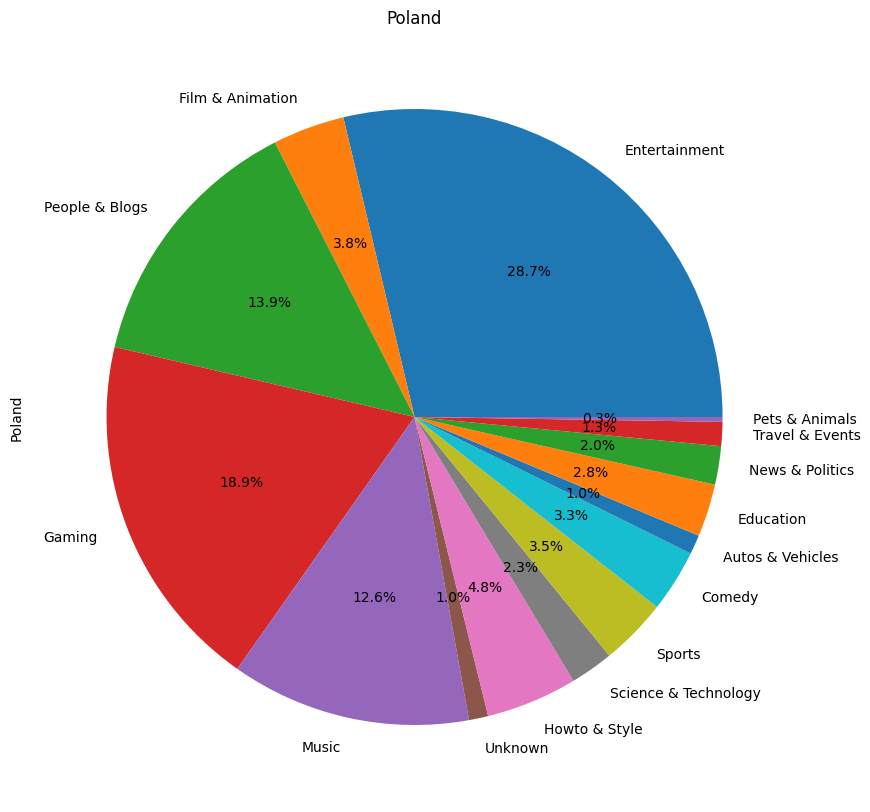

In [12]:
pie_categories_poland = categories_df["Poland"].plot.pie(
    title="Poland", autopct="%1.1f%%", figsize=(10, 10)
)

In [18]:
pie_categories_us = categories_df["United States"].plot.pie(
    title="United States", autopct="%1.1f%%", figsize=(10, 10)
)

ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 1000x1000 with 1 Axes>

In [19]:
entertainment_pl = [
    channel for channel in pl_data if channel["channel"]["category"] == "Entertainment"
]
film_animation_pl = [
    channel for channel in pl_data if channel["channel"]["category"] == "Film & Animation"
]
people_blogs_pl = [
    channel for channel in pl_data if channel["channel"]["category"] == "People & Blogs"
]
howto_style_pl = [
    channel for channel in pl_data if channel["channel"]["category"] == "Howto & Style"
]
comedy_pl = [channel for channel in pl_data if channel["channel"]["category"] == "Comedy"]

entertainment_us = [
    channel for channel in us_data if channel["channel"]["category"] == "Entertainment"
]
film_animation_us = [
    channel for channel in us_data if channel["channel"]["category"] == "Film & Animation"
]
people_blogs_us = [
    channel for channel in us_data if channel["channel"]["category"] == "People & Blogs"
]
howto_style_us = [
    channel for channel in us_data if channel["channel"]["category"] == "Howto & Style"
]
comedy_us = [channel for channel in us_data if channel["channel"]["category"] == "Comedy"]

In [20]:
for idx, channel in enumerate(pl_data):
    try:
        concat_channel_titles = " ".join([video["title"] for video in channel["videos"]])
        clean = preprocess_text(concat_channel_titles)
        lang = detect(clean)
        channel["channel"]["language"] = lang
        
    except lang_detect_exception.LangDetectException:
        print(f"Language detection failed for channel {channel['channel']['name']}")
        channel["channel"]["language"] = "pl"
    pl_data[idx] = channel

Language detection failed for channel TheNitroZyniak
Language detection failed for channel MagdalenaMariaMonika
Language detection failed for channel ZDROWE i SMACZNE przepisy.
Language detection failed for channel skkf


In [21]:
for idx, channel in enumerate(us_data):
    try:
        concat_channel_titles = " ".join([video["title"] for video in channel["videos"]])
        clean = preprocess_text(concat_channel_titles)
        lang = detect(clean)
        channel["channel"]["language"] = lang
        
    except lang_detect_exception.LangDetectException:
        print(f"Language detection failed for channel {channel['channel']['name']}")
        channel["channel"]["language"] = "en"
    us_data[idx] = channel

In [23]:
only_pl = list(filter(lambda x: x["channel"]["language"] == "pl", pl_data))
for channel in tqdm(only_pl, total=len(only_pl), desc="Preprocessing Polish videos"):
    print(f"Processing channel {channel['channel']['name']}")
    for video in channel["videos"]:
        try:
            clean_title = preprocess_text(video["title"], "pl")
            video["title"] = clean_title
            clean_description = preprocess_text(video["description"], "pl")
            video["description"] = clean_description
        except Exception as e:
            print(f"Preprocessing failed for video {video['title']}: {e}")
            continue
    only_pl[only_pl.index(channel)] = channel

Preprocessing Polish videos:   0%|          | 0/327 [00:00<?, ?it/s]

Processing channel Blowek


KeyboardInterrupt: 

In [ ]:
only_us = list(filter(lambda x: x["channel"]["language"] == "en", pl_data))
for channel in tqdm(only_us, total=len(only_us), desc="Preprocessing Englisn videos"):
    print(f"Processing channel {channel['channel']['name']}")
    for video in channel["videos"]:
        try:
            clean_title = preprocess_text(video["title"], "en")
            video["title"] = clean_title
            clean_description = preprocess_text(video["description"], "en")
            video["description"] = clean_description
        except Exception as e:
            print(f"Preprocessing failed for video {video['title']}: {e}")
            continue
    only_us[only_us.index(channel)] = channel